In [23]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from utils.common import show,fillColor
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def getIdcard(ori_img,debug=False):
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
    matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    show(ori_img,"原始图",debug=debug)
    #使用第一个像素点填充10%大屏到外围，防止图片边框没有闭合
    rgb = ori_img[0, 0]
    img = fillColor(ori_img, [0, 0, 0])
    #img = fillColor(ori_img, [int(rgb[0]), int(rgb[1]), int(rgb[2])])
    show(img,"填充图",cmap="gray",debug=debug)
    #%%
    #转换成灰度图
    grayImg=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show(grayImg,"灰度图",cmap="gray",debug=debug)
    grayImg=cv2.medianBlur(grayImg,3)
    # grayImg=cv2.GaussianBlur(grayImg,(5,5),0,0)
    show(grayImg,"高斯降噪图",cmap="gray",debug=debug)
    """
    二值处理，非黑即白。这里通过cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU，使用OpenCV的大津法二值化，对图像进行处理，经过处理后的图像，更加清晰的分辨出了背景和身份证的区域。
    """
    _,dst=cv2.threshold(grayImg,165,255,cv2.THRESH_BINARY_INV)
    show(dst, "二值化图",cmap="gray",debug=debug)
    #dst=cv2.adaptiveThreshold(grayImg,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,3)
    kernel = np.ones((3, 3), np.uint8)
    #進行开运算，腐蚀掉噪点，然后进行膨胀
    morph_open = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    show(morph_open,"morph_open開運算",cmap="gray",debug=debug)
    # 将图像中的目标物体（白色）膨胀（变大），同时减小目标物体与背景（黑色）之间的距离
    dilate = cv2.dilate(morph_open, kernel, iterations=12)
    show(dilate, "膨胀",cmap="gray",debug=debug)
    canny = cv2.Canny(dilate, 100, 150)
    show(canny,"canny边框图",cmap="gray",debug=debug)
    dilateImg = cv2.dilate(canny, kernel, iterations=12)
    show(dilateImg,"canny边框膨胀",cmap="gray",debug=debug)
    # morph_close = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
    # show(morph_close,"canny边框膨胀后腐蚀",cmap="gray",debug=debug)
    #轮廓检测
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    show(cv2.drawContours(img.copy(), contours, -1, (0, 0, 255), 3),"绘制边框",debug=debug)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    image_copy = img.copy()
    res = cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 3)
    show(res, "contours",debug=debug)
    approx = cv2.approxPolyDP(contours, 0.05 * cv2.arcLength(contours, True), True)
    image_copy = img.copy()
    cv2.drawContours(image_copy, [approx], 0, (0, 255, 0), 3)
    show(image_copy, "contours矩形",debug=debug)
    #获取最大边框的坐标
    x,y,w,h = cv2.boundingRect(approx)
    print(x,y,w,h)
    roi = img[y:y+h, x:x+w]
    if w < h:
        roi = np.rot90(roi)
    return roi

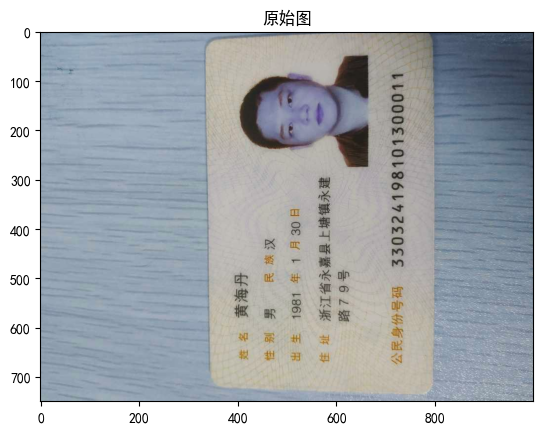

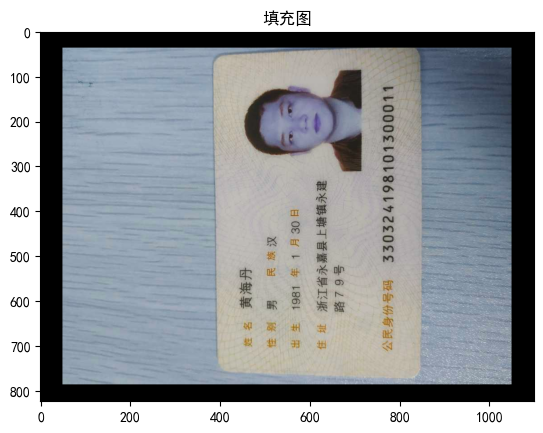

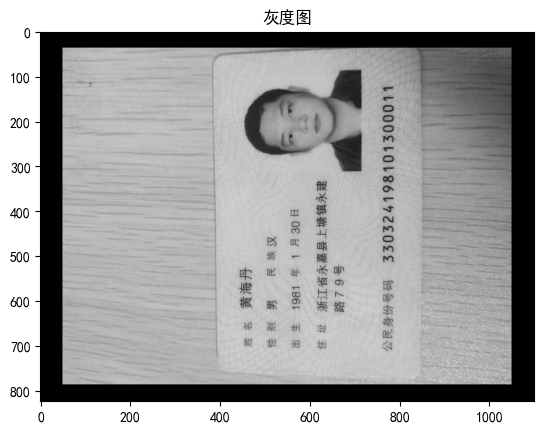

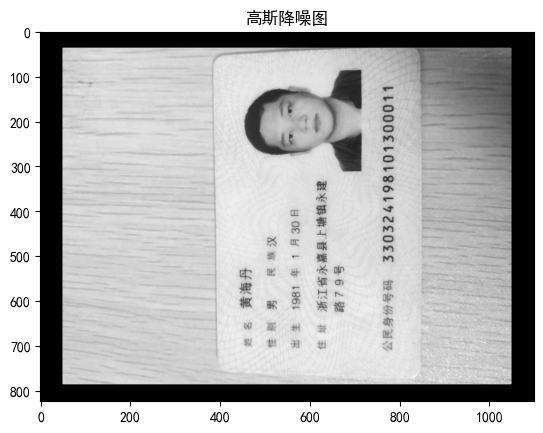

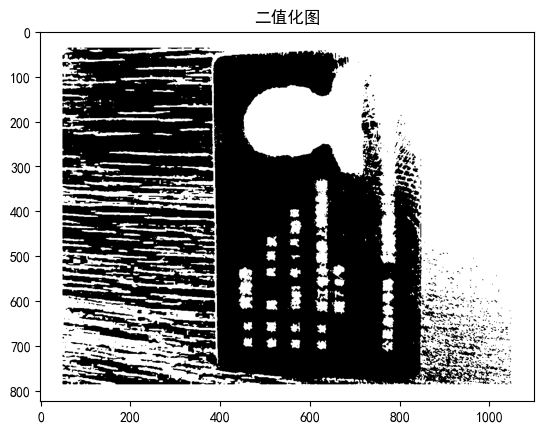

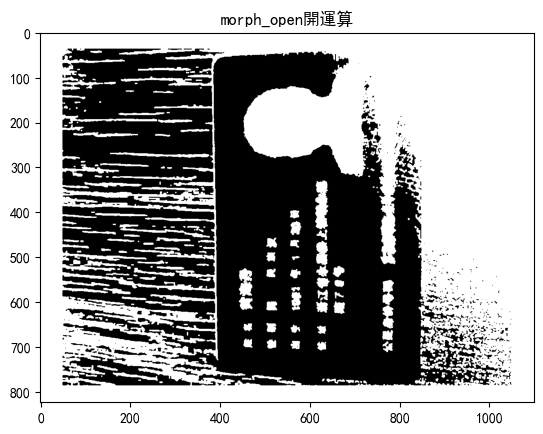

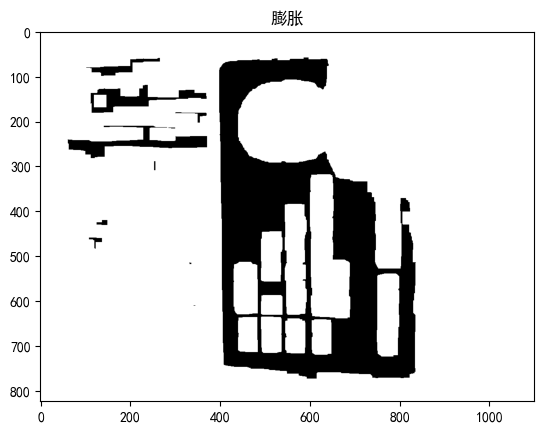

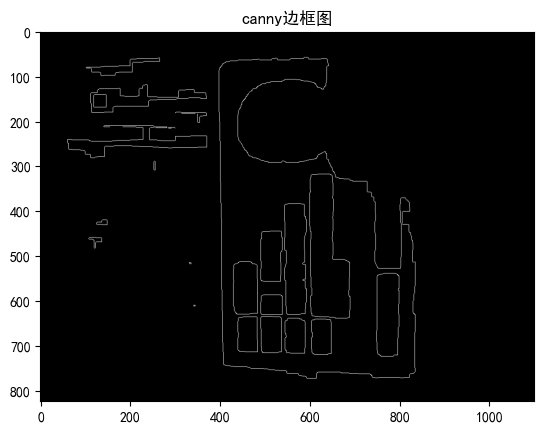

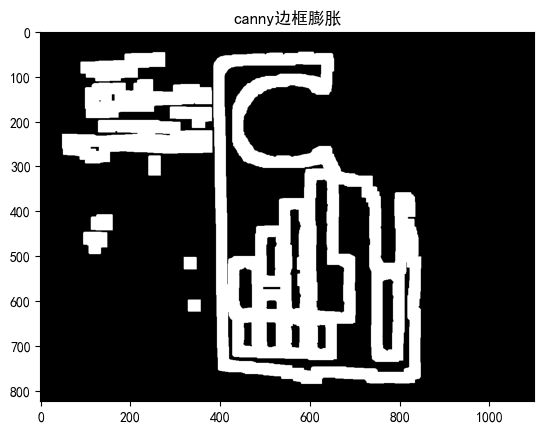

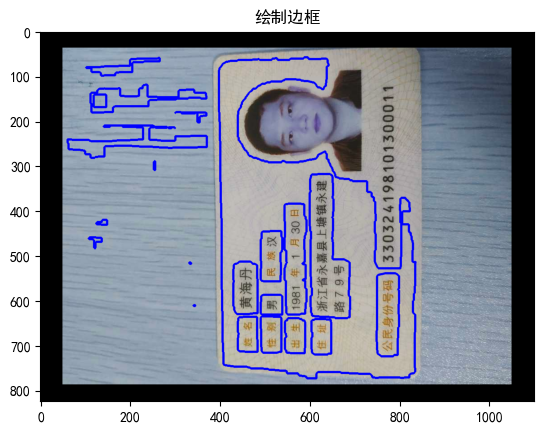

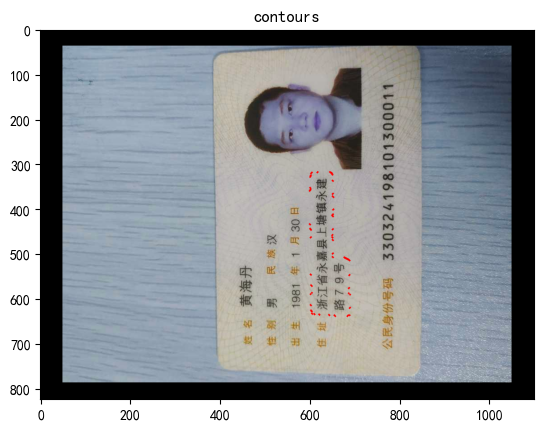

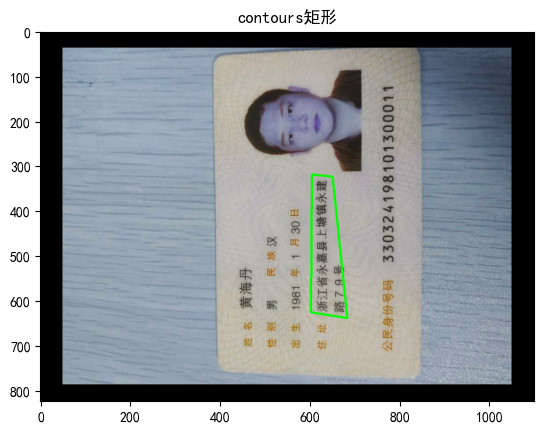

603 319 82 321


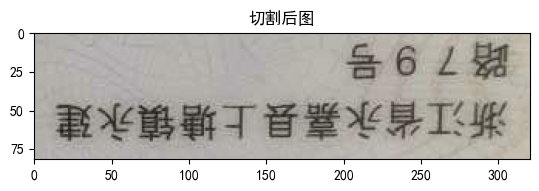

In [24]:
img=cv2.imread("./idcard2.png")
roi=getIdcard(img,True)
show(roi,"切割后图",cmap="gray",debug=True)